In [1]:
# Görüntü Sahteciliği Tespiti - Derin Öğrenme Projesi

## 0. Ortam ve Versiyon Kontrolü
## 1. Veri Seti Tanımı ve Klasör Yolları
## 2. Veri Ön İşleme ve Augmentasyon Planı
## 3. Dataset ve DataLoader Yapısı
## 4. Basit CNN (Baseline Model) Planı
## 5. Loss, Optimizer ve Metriklerin Planı
## 6. Eğitim ve Doğrulama Döngüsü
## 7. Pretrained Model (ResNet/EfficientNet) Planı
## 8. Değerlendirme, Metrik ve Grafikler
## 9. Tahmin Fonksiyonu (Demo) Planı
## 10. Model ve Çıktıların Kaydedilmesi


In [2]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# rastgelelik için seed ayarla
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

# cihaz ayarı
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("CPU kullanılıyor")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Kullanılan cihaz: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.59 GB
PyTorch version: 2.9.1+cu126
CUDA available: True


Dosya yolları:
Proje dizini : C:\Users\PC\Desktop\deepCNN
Train dizini : C:\Users\PC\Desktop\deepCNN\data\train
Test dizini  : C:\Users\PC\Desktop\deepCNN\data\test
Model dizini : C:\Users\PC\Desktop\deepCNN\models
Output dizini: C:\Users\PC\Desktop\deepCNN\outputs
Train ve test klasörleri bulundu.
Train veri listesi hazırlanıyor
Test veri listesi hazırlanıyor
Toplam 185,015 görsel yüklendi

Veri azaltma uygulanıyor... (oran = 0.5)
Veri İstatistikleri
Train sınıf dağılımı:
class
AI      52508
REAL    25000
Name: count, dtype: int64

Test sınıf dağılımı:
class
AI      20000
REAL    10000
Name: count, dtype: int64


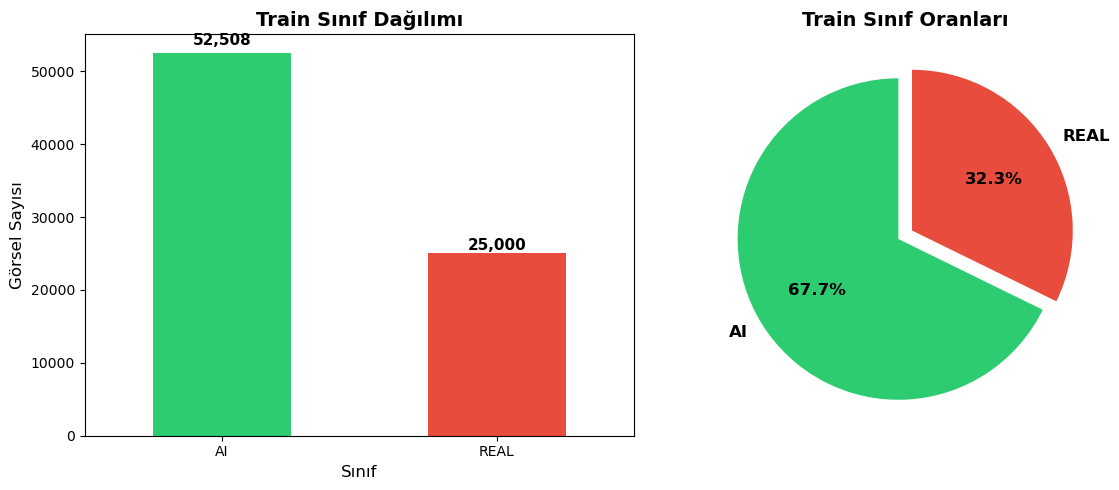

Grafik kaydedildi: C:\Users\PC\Desktop\deepCNN\outputs\class_distribution.png


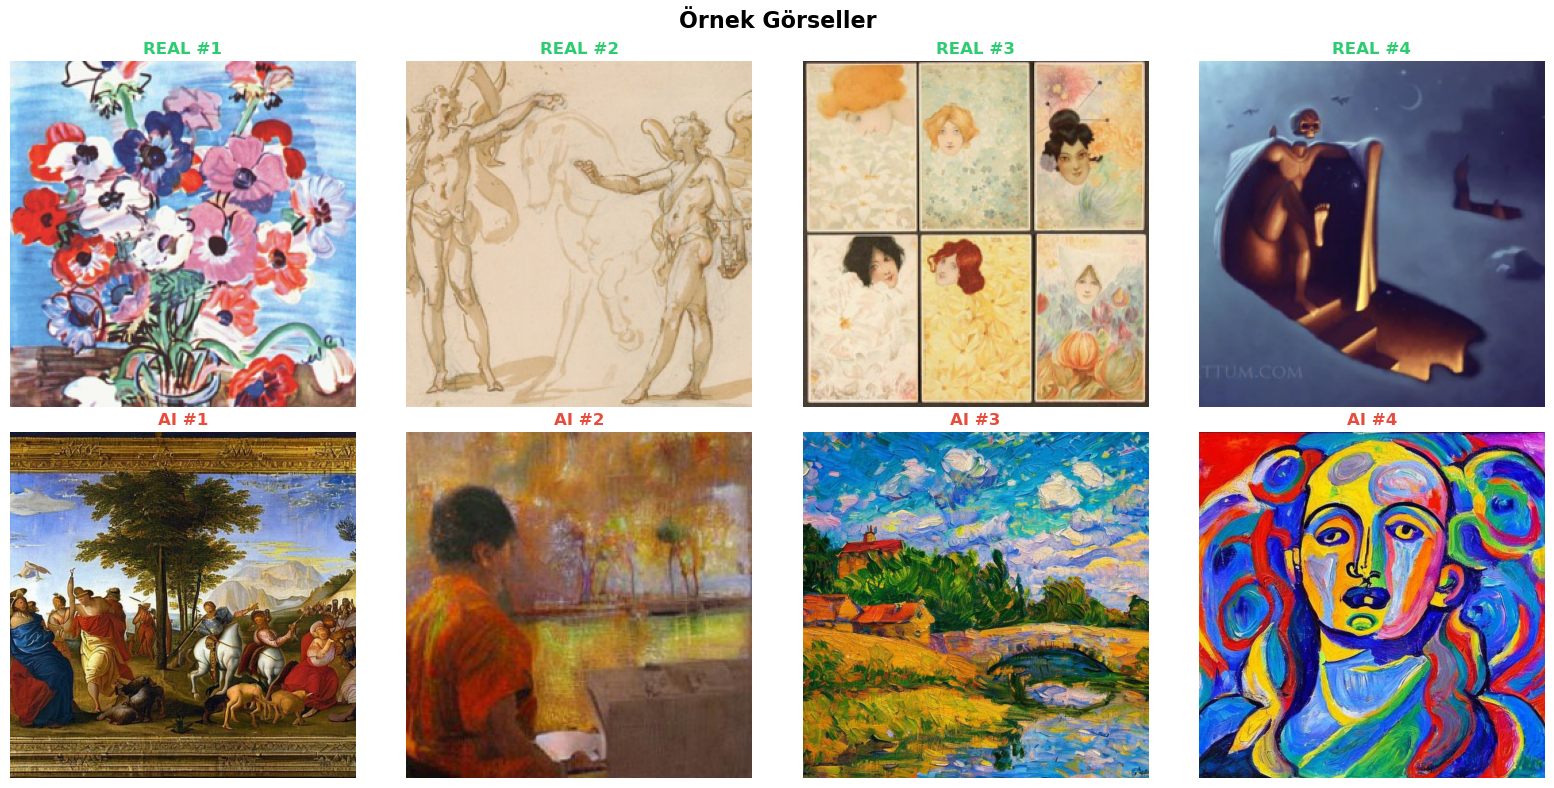

Grafik kaydedildi: C:\Users\PC\Desktop\deepCNN\outputs\sample_images.png


In [3]:
proje_yolu = Path(r"C:\Users\PC\Desktop\deepCNN")

# Veri klasörleri
DATA_DIR  = proje_yolu / "data"
train_yol = DATA_DIR / "train"
test_yol  = DATA_DIR / "test"

# Model ve çıktı klasörleri
model_yolu  = proje_yolu / "models"
output_yolu = proje_yolu / "outputs"

model_yolu.mkdir(exist_ok=True)
output_yolu.mkdir(exist_ok=True)

print("Dosya yolları:")
print(f"Proje dizini : {proje_yolu}")
print(f"Train dizini : {train_yol}")
print(f"Test dizini  : {test_yol}")
print(f"Model dizini : {model_yolu}")
print(f"Output dizini: {output_yolu}")

# Klasör kontrolü
if not train_yol.exists():
    raise FileNotFoundError(f"Train dosya yolu bulunamadı: {train_yol}")
if not test_yol.exists():
    print("Uyarı: test klasörü bulunamadı, sadece train kullanılacak.")
else:
    print("Train ve test klasörleri bulundu.")

def klasorden_veri_ekle(ana_klasor, split_adi, liste):
    for stil_klasoru in ana_klasor.iterdir():
        if not stil_klasoru.is_dir():
            continue  # dosya ise geç
        klasor_adi = stil_klasoru.name.lower()
        
        # Klasör adına göre etiket belirle
        if klasor_adi.startswith("ai_"):
            etiket = 0
            sinif  = "AI"
        else:
            etiket = 1
            sinif  = "REAL"
            
        for f in stil_klasoru.glob("*"):
            if f.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                liste.append({
                    "path":  str(f),
                    "label": etiket,
                    "class": sinif,
                    "split": split_adi
                })

data = []

print("Train veri listesi hazırlanıyor")
klasorden_veri_ekle(train_yol, "train", data)

if test_yol.exists():
    print("Test veri listesi hazırlanıyor")
    klasorden_veri_ekle(test_yol, "test", data)

# DataFrame oluştur
df = pd.DataFrame(data)
print(f"Toplam {len(df):,} görsel yüklendi")

REDUCTION_RATE = 0.5   
if REDUCTION_RATE < 1.0:
    print(f"\nVeri azaltma uygulanıyor... (oran = {REDUCTION_RATE})")
    train_df = df[df["split"] == "train"].copy()
    test_df  = df[df["split"] == "test"].copy()
    
    # Her sınıftan aynı oranda örnek al (REAL / AI dengesi korunur)
    train_df = (
        train_df
        .groupby("class", group_keys=False)
        .apply(lambda x: x.sample(frac=REDUCTION_RATE, random_state=SEED))
        .reset_index(drop=True)
    )
    
    df = pd.concat([train_df, test_df], ignore_index=True)
else:
    print("\nVeri azaltma uygulanmıyor (REDUCTION_RATE = 1.0)")

train_df = df[df["split"] == "train"]
test_df  = df[df["split"] == "test"]

print("Veri İstatistikleri")
print("Train sınıf dağılımı:")
print(train_df["class"].value_counts())
if len(test_df) > 0:
    print("\nTest sınıf dağılımı:")
    print(test_df["class"].value_counts())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_df["class"].value_counts().plot(kind="bar", color=["#2ecc71", "#e74c3c"])
plt.title("Train Sınıf Dağılımı", fontsize=14, fontweight="bold")
plt.xlabel("Sınıf", fontsize=12)
plt.ylabel("Görsel Sayısı", fontsize=12)
plt.xticks(rotation=0)
for i, v in enumerate(train_df["class"].value_counts().values):
    plt.text(i, v + max(10, int(v*0.02)), f"{v:,}", ha="center", fontsize=11, fontweight="bold")

plt.subplot(1, 2, 2)
renkler = ["#2ecc71", "#e74c3c"]
explode = (0.05, 0.05)
train_class_counts = train_df["class"].value_counts()
plt.pie(
    train_class_counts.values,
    labels=train_class_counts.index,
    autopct="%1.1f%%",
    colors=renkler,
    explode=explode,
    startangle=90,
    textprops={"fontsize": 12, "fontweight": "bold"}
)
plt.title("Train Sınıf Oranları", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig(output_yolu / "class_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
print(f"Grafik kaydedildi: {output_yolu / 'class_distribution.png'}")

def show_sample_images(df, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    train_df = df[df["split"] == "train"]

    real_ornekler = train_df[train_df["class"] == "REAL"].sample(
        min(4, len(train_df[train_df["class"] == "REAL"])),
        random_state=SEED
    )
    ai_ornekler = train_df[train_df["class"] == "AI"].sample(
        min(4, len(train_df[train_df["class"] == "AI"])),
        random_state=SEED
    )

    for i, (index, row) in enumerate(real_ornekler.iterrows()):
        img = Image.open(row["path"]).convert("RGB")
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"REAL #{i+1}", fontsize=12, fontweight="bold", color="#2ecc71")
        axes[0, i].axis("off")

    for i, (index, row) in enumerate(ai_ornekler.iterrows()):
        img = Image.open(row["path"]).convert("RGB")
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"AI #{i+1}", fontsize=12, fontweight="bold", color="#e74c3c")
        axes[1, i].axis("off")

    plt.suptitle("Örnek Görseller", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.savefig(output_yolu / "sample_images.png", dpi=300, bbox_inches="tight")
    plt.show()

show_sample_images(df)
print(f"Grafik kaydedildi: {output_yolu / 'sample_images.png'}")


In [4]:
class ArtworkDataset(Dataset):
    def __init__(self, image_paths, etiketler, transform=None):
        self.image_paths = image_paths
        self.etiketler = etiketler
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_yol = self.image_paths[index]
        image = Image.open(img_yol).convert('RGB')
        label = self.etiketler[index]
        
        if self.transform:
            image = self.transform(image)
        return image, label

print("Veri dönuşümleri tanımlanıyor")

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.7), 
    transforms.RandomRotation(30),  
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# validasyon ve test transform
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

train_paths = train_df['path'].tolist()
train_labels = train_df['label'].tolist()

if len(test_df) == 0:
    print("Test seti bulunamadi, train'den ayriliyor...")
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        train_paths, train_labels, test_size=0.15, random_state=SEED, stratify=train_labels
    )
else:
    test_paths = test_df['path'].tolist()
    test_labels = test_df['label'].tolist()

# validation ayır
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, random_state=SEED, stratify=train_labels
)

print("Veri Bölme İstatistikleri")
print(f"Training set: {len(train_paths):,} gorsel")
print(f"Validation set: {len(val_paths):,} gorsel")
print(f"Test set: {len(test_paths):,} gorsel")

train_real = sum(train_labels)
train_ai = len(train_labels) - train_real
print(f"\nEgitim seti sinif dagilimi:")
print(f" REAL: {train_real:,} | AI: {train_ai:,} | Oran: {train_real/train_ai:.2f}")

BATCH_BOYUTU = 32
NUM_WORKERS = 0

print(f"DataLoader oluşturuluyor")
print(f"Batch boyutu: {BATCH_BOYUTU}")
print(f"Worker sayısı: {NUM_WORKERS}")

train_dataset = ArtworkDataset(train_paths, train_labels, transform=train_transform)
val_dataset = ArtworkDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = ArtworkDataset(test_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_BOYUTU, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_BOYUTU, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_BOYUTU, shuffle=False, num_workers=NUM_WORKERS)

print("DataLoader hazir")
print(f"Batch info:")
print(f"Train: {len(train_loader)} batch")
print(f"Val: {len(val_loader)} batch")
print(f"Test: {len(test_loader)} batch")

try:
    sample_batch = next(iter(train_loader))
    print(f"\nIlk batch kontrol: {sample_batch[0].shape}")
    print(f" Batch size: {sample_batch[0].shape[0]}")
    print(f" Image size: {sample_batch[0].shape[1:]} (C, H, W)")
except Exception as e:
    print(f"DataLoader error: {e}")


Veri dönuşümleri tanımlanıyor
Veri Bölme İstatistikleri
Training set: 65,881 gorsel
Validation set: 11,627 gorsel
Test set: 30,000 gorsel

Egitim seti sinif dagilimi:
 REAL: 21,250 | AI: 44,631 | Oran: 0.48
DataLoader oluşturuluyor
Batch boyutu: 32
Worker sayısı: 0
DataLoader hazir
Batch info:
Train: 2059 batch
Val: 364 batch
Test: 938 batch

Ilk batch kontrol: torch.Size([32, 3, 224, 224])
 Batch size: 32
 Image size: torch.Size([3, 224, 224]) (C, H, W)


In [5]:
# Base model - Resnet50
class ResNet50Classifier(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50Classifier, self).__init__()
        
        print("ResNet50 yükleniyor")
        self.resnet = models.resnet50(pretrained=pretrained)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        print("ResNet50 hazırlandı")
    
    def forward(self, x):
        return self.resnet(x)

model = ResNet50Classifier(pretrained=True).to(device)

toplam_params = sum(p.numel() for p in model.parameters())
egitilir_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model bilgisi:")
print(f"Total parameters: {toplam_params:,}")
print(f"Trainable parameters: {egitilir_params:,}")
print(f"Model size: ~{toplam_params * 4 / (1024**2):.1f} MB")
print(f"Device: {next(model.parameters()).device}")


#Eğitim Ayarları
EPOCH_SAYISI = 5
LEARNING_RATE = 3e-4 
PATIENCE = 5

# loss function
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2  
)

# early stopping
best_val_loss = float('inf')
sabir_sayaci = 0

# training history
gecmis = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

print(f"""
Hiperparametreler:
Epoch: {EPOCH_SAYISI}
Batch: {BATCH_BOYUTU}
Learning rate: {LEARNING_RATE}
Early stopping: {PATIENCE}
""")

def train_epoch(model, dataloader, criterion, optimizer, cihaz):
    model.train()
    running_loss = 0.0
    dogru = 0
    toplam = 0
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images = images.to(cihaz)
        labels = labels.float().to(cihaz)
        
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        toplam += labels.size(0)
        dogru += (predicted == labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * dogru / toplam:.2f}%'
        })
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * dogru / toplam
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, cihaz):
    model.eval()
    running_loss = 0.0
    dogru = 0
    toplam = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        for images, labels in pbar:
            images = images.to(cihaz)
            labels = labels.float().to(cihaz)
            
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            toplam += labels.size(0)
            dogru += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * dogru / toplam:.2f}%'
            })
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * dogru / toplam
    return epoch_loss, epoch_acc

print("Fonksiyonlar hazır")


ResNet50 yükleniyor
ResNet50 hazırlandı
Model bilgisi:
Total parameters: 23,510,081
Trainable parameters: 23,510,081
Model size: ~89.7 MB
Device: cuda:0

Hiperparametreler:
Epoch: 5
Batch: 32
Learning rate: 0.0003
Early stopping: 5

Fonksiyonlar hazır


In [6]:
EN_IYI_MODEL_PATH = model_yolu / "best_resnet50_model.pth"

for epoch in range(EPOCH_SAYISI):
    print(f"\nEpoch [{epoch+1}/{EPOCH_SAYISI}]")
    
    # egitim
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # validasyon
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # gecmise ekle
    gecmis['train_loss'].append(train_loss)
    gecmis['val_loss'].append(val_loss)
    gecmis['train_acc'].append(train_acc)
    gecmis['val_acc'].append(val_acc)
    
    # scheduler 
    scheduler.step(val_loss)
    
    # sonuçlar
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # en iyi model 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        sabir_sayaci = 0
        torch.save(model.state_dict(), EN_IYI_MODEL_PATH)
        print(f"Model kaydedildi ({EN_IYI_MODEL_PATH})")
    else:
        sabir_sayaci += 1
        print(f"Patience: {sabir_sayaci}/{PATIENCE}")
    
    # early stopping 
    if sabir_sayaci >= PATIENCE:
        print("Early stopping!")
        break

# en iyi modeli yukle
print("Model yükleniyor")
model.load_state_dict(torch.load(EN_IYI_MODEL_PATH))
model.eval()
print("Model yüklendi")



Epoch [1/5]


Train Loss: 0.1745 | Train Acc: 93.12%
Val Loss: 0.0597 | Val Acc: 98.10%
Model kaydedildi (C:\Users\PC\Desktop\deepCNN\models\best_resnet50_model.pth)

Epoch [2/5]


Train Loss: 0.0860 | Train Acc: 96.76%
Val Loss: 0.3476 | Val Acc: 88.17%
Patience: 1/5

Epoch [3/5]


Train Loss: 0.0630 | Train Acc: 97.71%
Val Loss: 0.4109 | Val Acc: 85.44%
Patience: 2/5

Epoch [4/5]


Train Loss: 0.0505 | Train Acc: 98.21%
Val Loss: 0.6226 | Val Acc: 82.37%
Patience: 3/5

Epoch [5/5]


Train Loss: 0.0184 | Train Acc: 99.35%
Val Loss: 0.2034 | Val Acc: 92.53%
Patience: 4/5
Model yükleniyor
Model yüklendi


Test tahminleri yapiliyor


Testing: 100%|██████████| 938/938 [09:50<00:00,  1.59it/s]


-Test Sonuçları-
Accuracy: 0.9785 (97.85%)
Precision: 0.9583
Recall: 0.9781
F1-Score: 0.9681
ROC AUC: 0.9977
HEDEF KONTROLU:
F1-Score >= 0.85: BASARILI (0.9681)
Accuracy >= 0.90: BASARILI (0.9785)
ROC AUC >= 0.85: BASARILI (0.9977)
Sınıflandırma Sonucu:
              precision    recall  f1-score   support

          AI       0.99      0.98      0.98     20000
        REAL       0.96      0.98      0.97     10000

    accuracy                           0.98     30000
   macro avg       0.97      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000



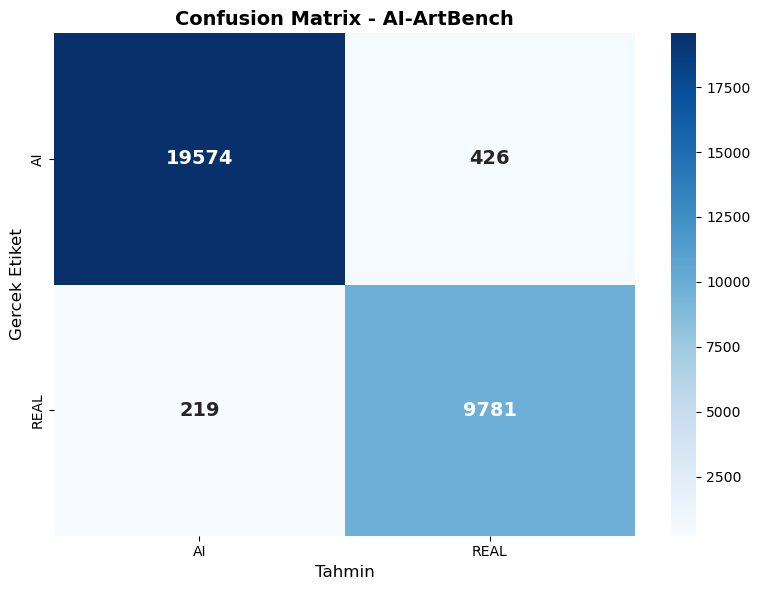

Grafik kaydedildi:  C:\Users\PC\Desktop\deepCNN\outputs\confusion_matrix.png


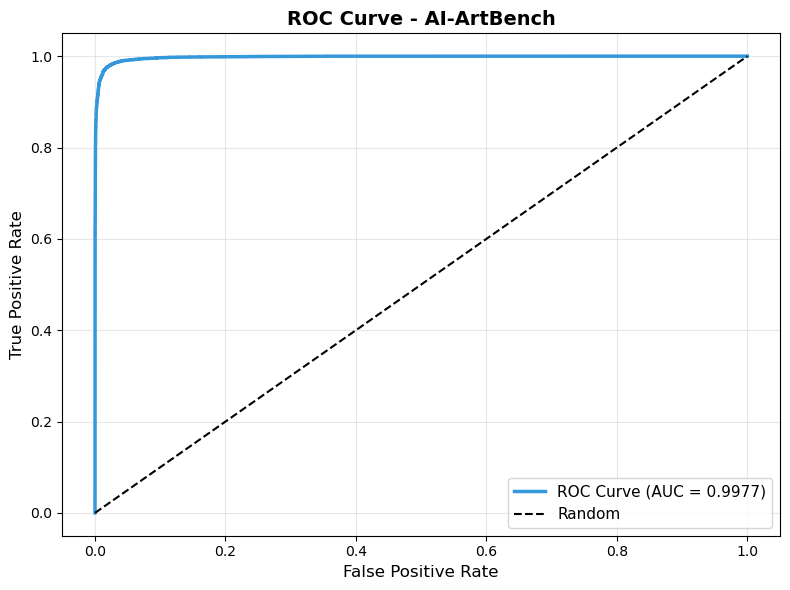

Grafik kaydedildi:  C:\Users\PC\Desktop\deepCNN\outputs\roc_curve.png
Model Raporu

Model: ResNet50
Dataset: AI-ArtBench (180K+ images)
Training set: 65881 görsel
Validation set: 11627 görsel
Test set: 30000 görsel
Total epochs: 5
Best val loss: 0.0597

Test Results:
- Accuracy: 97.85%
- F1-Score: 0.9681
- ROC AUC: 0.9977



In [7]:
all_preds = []
all_labels = []
all_probs = []

print("Test tahminleri yapiliyor")
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(device)
        outputs = model(images).squeeze()
        
        probs = outputs.cpu().numpy()
        preds = (outputs > 0.5).float().cpu().numpy()
        
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# metrik hesapla
dogruluk = accuracy_score(all_labels, all_preds)
kesinlik = precision_score(all_labels, all_preds)
duyarlilik = recall_score(all_labels, all_preds)
f1_skoru = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print("-Test Sonuçları-")
print(f"Accuracy: {dogruluk:.4f} ({dogruluk*100:.2f}%)")
print(f"Precision: {kesinlik:.4f}")
print(f"Recall: {duyarlilik:.4f}")
print(f"F1-Score: {f1_skoru:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("HEDEF KONTROLU:")
print(f"F1-Score >= 0.85: {'BASARILI' if f1_skoru >= 0.85 else 'YETERSIZ'} ({f1_skoru:.4f})")
print(f"Accuracy >= 0.90: {'BASARILI' if dogruluk >= 0.90 else 'YETERSIZ'} ({dogruluk:.4f})")
print(f"ROC AUC >= 0.85: {'BASARILI' if roc_auc >= 0.85 else 'YETERSIZ'} ({roc_auc:.4f})")

print("Sınıflandırma Sonucu:")
print(classification_report(all_labels, all_preds, target_names=['AI', 'REAL']))

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['AI', 'REAL'],
            yticklabels=['AI', 'REAL'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix - AI-ArtBench', fontsize=14, fontweight='bold')
plt.ylabel('Gercek Etiket', fontsize=12)
plt.xlabel('Tahmin', fontsize=12)
plt.tight_layout()
plt.savefig(output_yolu / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Grafik kaydedildi: ", output_yolu / 'confusion_matrix.png')

# ROC eğrisi
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=2.5, color='#3498db')
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - AI-ArtBench', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_yolu / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("Grafik kaydedildi: ", output_yolu / 'roc_curve.png')

print("Model Raporu")
print(f"""
Model: ResNet50
Dataset: AI-ArtBench (180K+ images)
Training set: {len(train_paths)} görsel
Validation set: {len(val_paths)} görsel
Test set: {len(test_paths)} görsel
Total epochs: {len(gecmis['train_loss'])}
Best val loss: {best_val_loss:.4f}

Test Results:
- Accuracy: {dogruluk*100:.2f}%
- F1-Score: {f1_skoru:.4f}
- ROC AUC: {roc_auc:.4f}
""")

In [1]:
from pathlib import Path

models_dir = Path.cwd().parent / "models"   # deepCNN/notebook içindeysen -> deepCNN/models
print("models_dir:", models_dir.resolve())

for fn in ["best_efficientnet_cbam.pth", "best_densenet121.pth", "best_resnet50_model.pth"]:
    print(fn, "->", (models_dir / fn).exists())


models_dir: C:\Users\PC\Desktop\deepCNN\models
best_efficientnet_cbam.pth -> True
best_densenet121.pth -> True
best_resnet50_model.pth -> True
